In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import adjusted_rand_score, accuracy_score
from graspologic.utils import remap_labels
from utils import calculate_dissim, calculate_dissim_unmatched, cluster_dissim, construct_df, plot_clustering, laplacian_dissim
import random

# Clustering Dissimilarity Matrices
We will run the same clustering algorithms (Agglomerative, K-Means, and GMM) on the dissimilarity matrices obtained from the previous notebook. 

The [MAMI Dataset](https://zenodo.org/record/6382386) is opensource, and we use Version 2. The labels used for clustering were based on taxonomy orders using information obtained from 'data/info/info.csv'.

## Load Data

In [2]:
from pathlib import Path

graphs_all = np.zeros((225, 200, 200))
species_list = []

npy_files = Path('../mami_data/conn').glob('*')
for i, file in enumerate(npy_files):
    graphs_all[i] = np.load(file)
    filestr = str(file).split('/')[-1]
    filestr = filestr.split('.')[0]
    species_list.append(filestr)

print(len(species_list))
    

225


In [3]:
random.seed(3)

# construct labels based on taxonomy orders
info_df = pd.read_csv('../mami_data/info.csv')
filenames = info_df.pop("Filename").to_list()
orders_all = info_df.pop("Order").to_list()

order_mapper = {}
for i, filename in enumerate(filenames):
    if orders_all[i] == 'Artiodactyla':
        orders_all[i] = 'Cetartiodactyla'
    order_mapper[filename] = orders_all[i]

labels_all = list(map(order_mapper.get, species_list))

# get subset of labels, graphs
orders = ['Chiroptera', 'Primates']
#orders = ['Chiroptera', 'Rodentia', 'Cetartiodactyla', 'Carnivora', 'Perissodactyla', 'Primates']
ind_ch = []
ind_pr = []
labels = []

for i, label in enumerate(labels_all):
    if label == 'Chiroptera':
        #labels.append(label)
        ind_ch.append(i)
    elif label == 'Primates':
        #labels.append(label)
        ind_pr.append(i)

ind_ch_samp = random.sample(ind_ch, len(ind_ch)//2)
ind_pr_samp = random.sample(ind_pr, len(ind_pr)//2)

ind = ind_ch_samp + ind_pr_samp
ind.sort()
graphs = graphs_all[ind]
labels = list(np.array(labels_all)[ind])

mapper = {}

for i, label in enumerate(set(labels)):
    mapper[label] = i
y = list(map(mapper.get, labels))

print(len(labels))
print(len(y))


38
38


## Agglomerative Clustering

Agglomerative clustering was used directly on the dissimilarity matrices, and the resulting linkage matrix and clusters were visualized with a heatmap below.

For each kernel, the accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index,  a similarity measure between two clusterings after being adjusted for chance, were reported. 

### Density

Accuracy: 0.47368421052631576
ARI: 0.18881245401510918


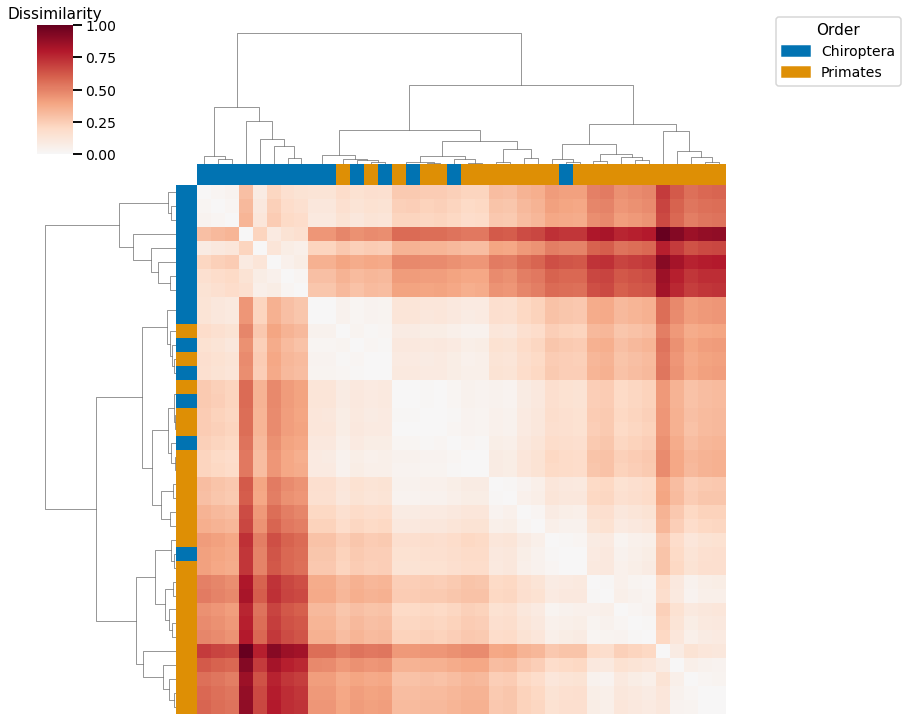

In [4]:
# calculate dissimilarity matrix
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

# cluster dissimilarity matrix
density_linkage_matrix, density_pred = cluster_dissim(scaled_density_dissim, y, method="agg")

# calculate accuracy and ARI
density_pred = remap_labels(y, density_pred)
density_agg_score = accuracy_score(y, density_pred)
density_agg_ari = adjusted_rand_score(y, density_pred)

print(f"Accuracy: {density_agg_score}")
print(f"ARI: {density_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_density_dissim, density_linkage_matrix)

### Average Edge Weight

Accuracy: 0.5263157894736842
ARI: -0.015714540820467866


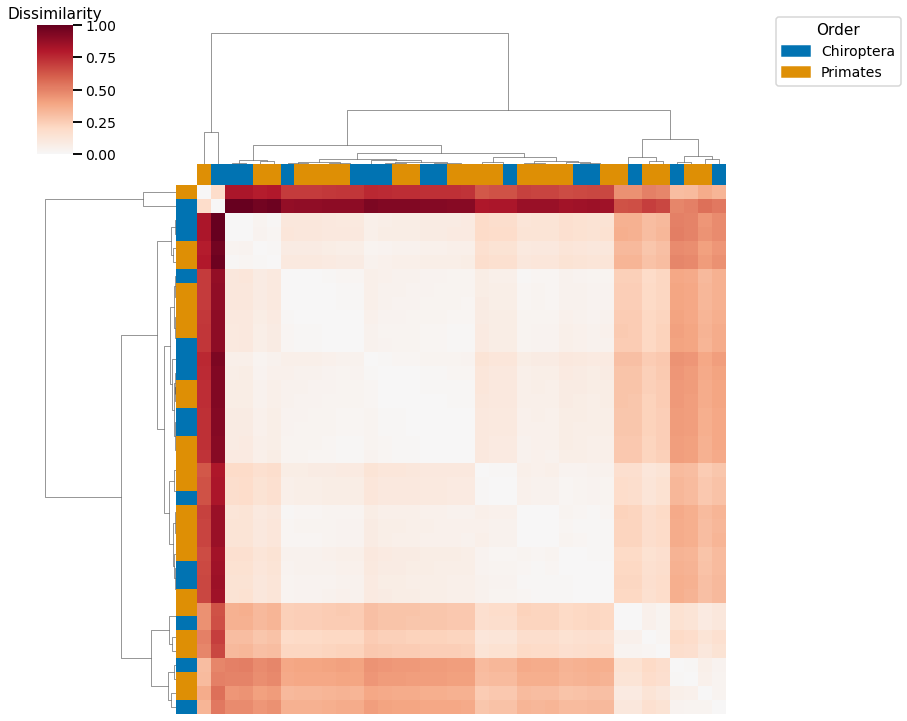

In [5]:
# calculate dissimilarity matrix
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

# cluster dissimilarity matrix
avgedgeweight_linkage_matrix, avgedgeweight_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method="agg")

# calculate accuracy and ARI
avgedgeweight_pred = remap_labels(y, avgedgeweight_pred)
avgedgeweight_agg_score = accuracy_score(y, avgedgeweight_pred)
avgedgeweight_agg_ari = adjusted_rand_score(y, avgedgeweight_pred)

print(f"Accuracy: {avgedgeweight_agg_score}")
print(f"ARI: {avgedgeweight_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_avgedgeweight_dissim, avgedgeweight_linkage_matrix)

### Average of Adjacency Matrix

Accuracy: 0.47368421052631576
ARI: 0.18881245401510918


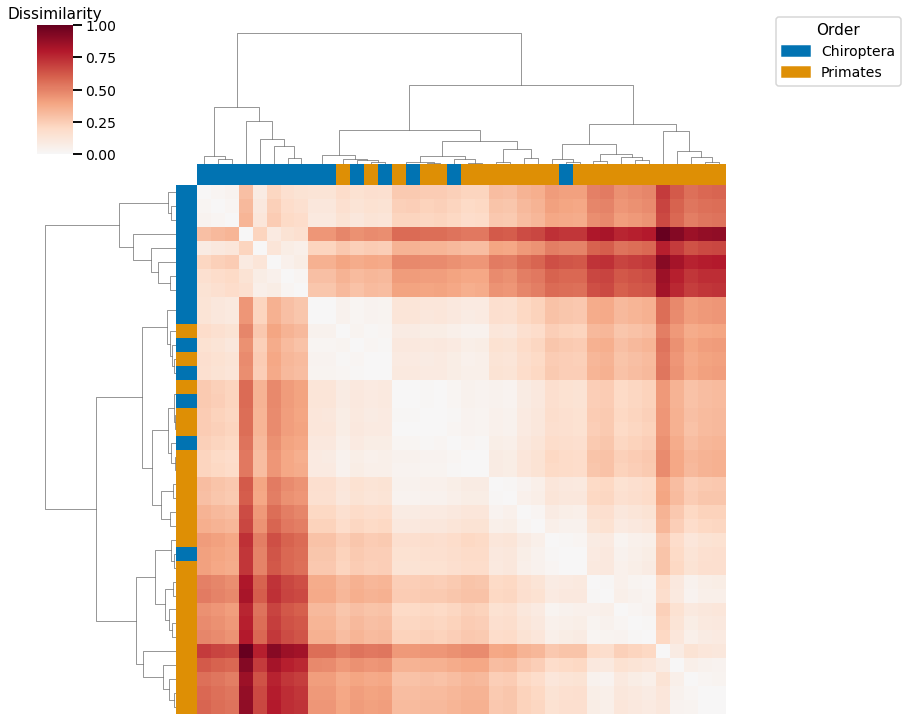

In [6]:
# calculate dissimilarity matrix
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

# cluster dissimilarity matrix
avgadjmat_linkage_matrix, avgadjmat_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method="agg")

# calculate accuracy and ARI
avgadjmat_pred = remap_labels(y, avgadjmat_pred)
avgadjmat_agg_score = accuracy_score(y, avgadjmat_pred)
avgadjmat_agg_ari = adjusted_rand_score(y, avgadjmat_pred)

print(f"Accuracy: {avgadjmat_agg_score}")
print(f"ARI: {avgadjmat_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_avgadjmat_dissim, avgadjmat_linkage_matrix)

### Spectral Distance (Laplacian)

Accuracy: 0.7105263157894737
ARI: 0.22573302657986197


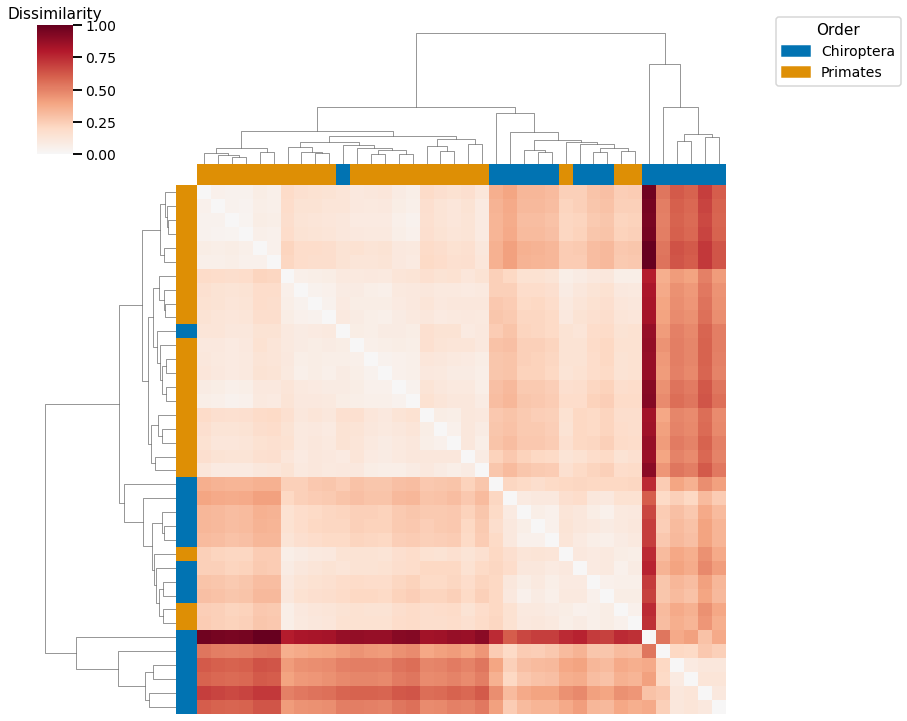

In [33]:
# calculate dissimilarity matrix
scaled_lap_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l2', normalize=True)

# cluster dissimilarity matrix
lap_linkage_matrix, lap_pred = cluster_dissim(scaled_lap_dissim, y, method="agg")

# calculate accuracy and ARI
lap_pred = remap_labels(y, lap_pred)
lap_agg_score = accuracy_score(y, lap_pred)
lap_agg_ari = adjusted_rand_score(y, lap_pred)

print(f"Accuracy: {lap_agg_score}")
print(f"ARI: {lap_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_lap_dissim, lap_linkage_matrix)

For unmatched datsets, we need to modify the kernels that use node degrees, node strength, and edge weights because they assume that the nodes are matches. Thus, we used the following modified function to calculate the dissimilarity matrices. 

### Node Degrees

Accuracy: 0.5526315789473685
ARI: 0.26245402472113355


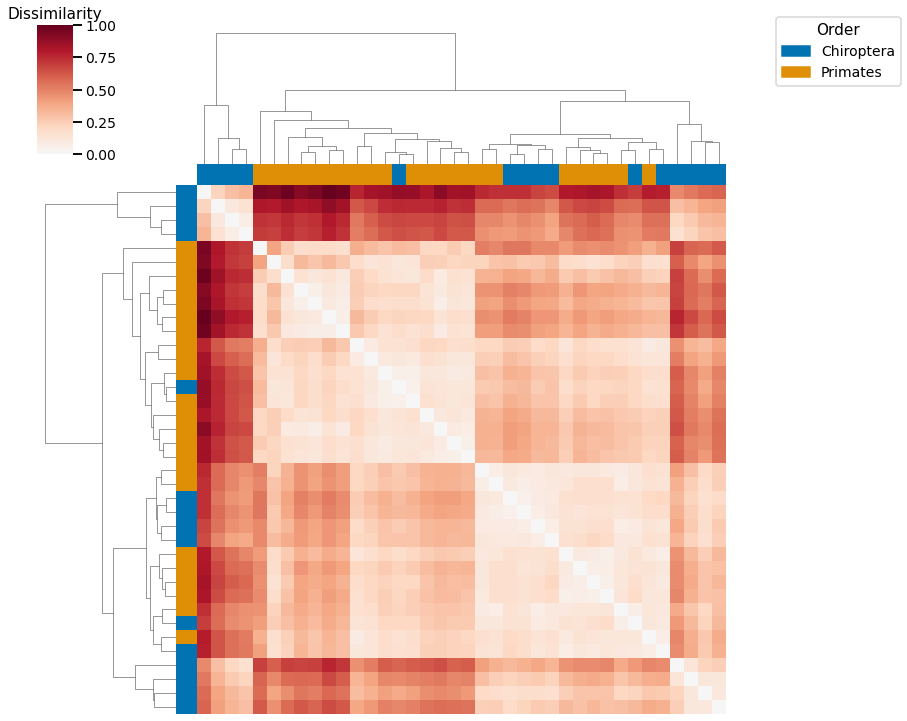

In [7]:
# calculate dissimilarity matrix
scaled_nodedeg_dissim = calculate_dissim_unmatched(graphs, method="degree", normalize=True)

# cluster dissimilarity matrix
nodedeg_linkage_matrix, nodedeg_pred = cluster_dissim(scaled_nodedeg_dissim, y, method="agg")

# calculate accuracy and ARI
nodedeg_pred = remap_labels(y, nodedeg_pred)
nodedeg_agg_score = accuracy_score(y, nodedeg_pred)
nodedeg_agg_ari = adjusted_rand_score(y, nodedeg_pred)

print(f"Accuracy: {nodedeg_agg_score}")
print(f"ARI: {nodedeg_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_nodedeg_dissim, nodedeg_linkage_matrix)

### Node Strength

Accuracy: 0.5263157894736842
ARI: 0.049173992850932276


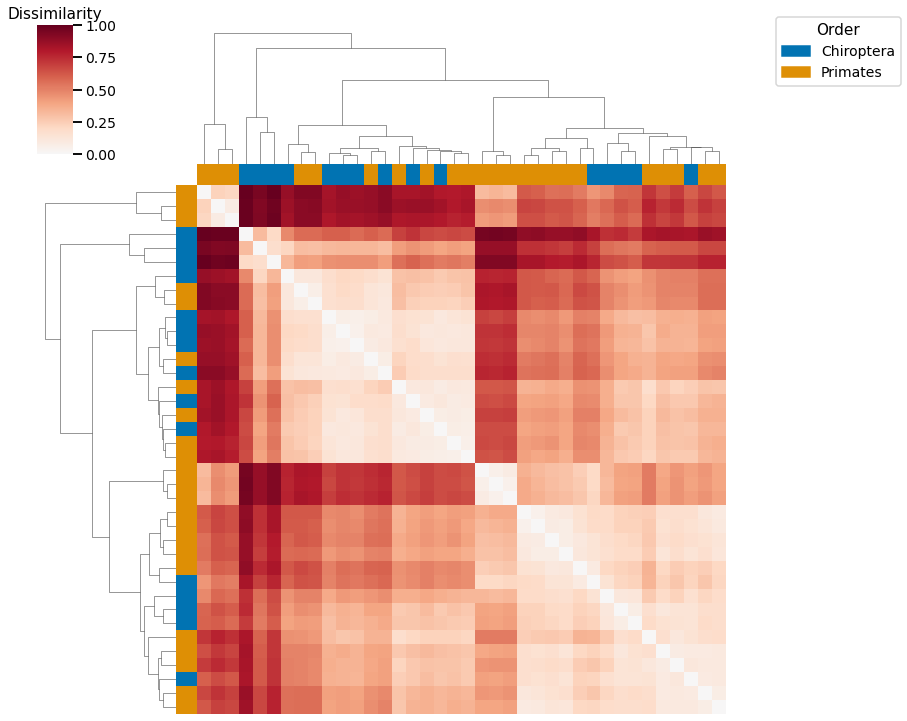

In [8]:
# calculate dissimilarity matrix
scaled_nodestr_dissim = calculate_dissim_unmatched(graphs, method="strength", normalize=True)

# cluster dissimilarity matrix
nodestr_linkage_matrix, nodestr_pred = cluster_dissim(scaled_nodestr_dissim, y, method="agg")

# calculate accuracy and ARI
nodestr_pred = remap_labels(y, nodestr_pred)
nodestr_agg_score = accuracy_score(y, nodestr_pred)
nodestr_agg_ari = adjusted_rand_score(y, nodestr_pred)

print(f"Accuracy: {nodestr_agg_score}")
print(f"ARI: {nodestr_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_nodestr_dissim, nodestr_linkage_matrix)

### Edge weights

Accuracy: 0.6578947368421053
ARI: 0.13120375826622144


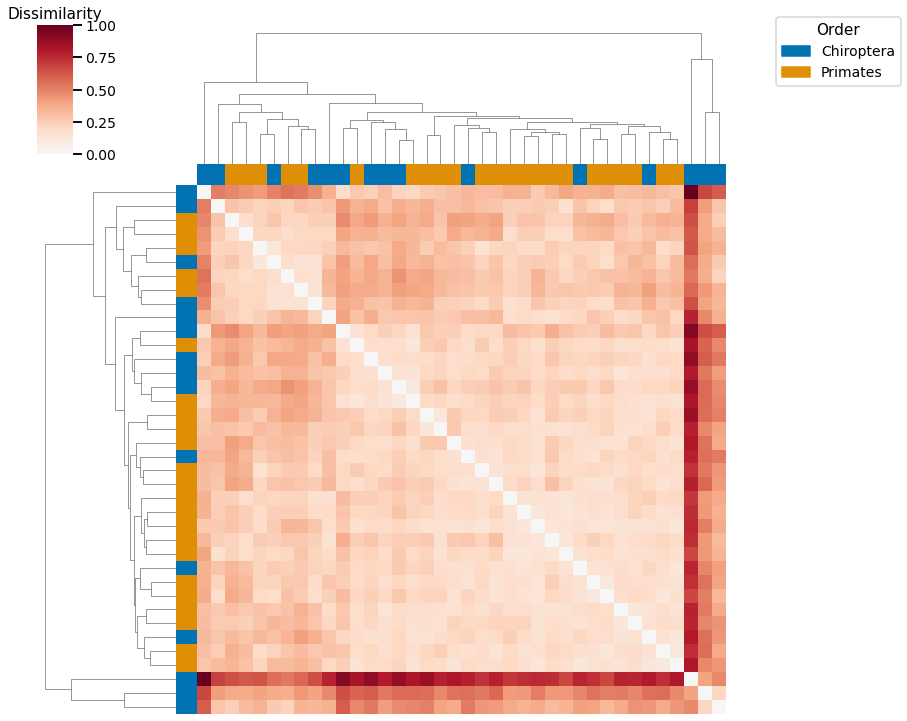

In [9]:
# calculate dissimilarity matrix
scaled_edgeweight_dissim = calculate_dissim_unmatched(graphs, method="edgeweight", normalize=True)

# cluster dissimilarity matrix
edgeweight_linkage_matrix, edgeweight_pred = cluster_dissim(scaled_edgeweight_dissim, y, method="agg")

# calculate accuracy and ARI
edgeweight_pred = remap_labels(y, edgeweight_pred)
edgeweight_agg_score = accuracy_score(y, edgeweight_pred)
edgeweight_agg_ari = adjusted_rand_score(y, edgeweight_pred)

print(f"Accuracy: {edgeweight_agg_score}")
print(f"ARI: {edgeweight_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_edgeweight_dissim, edgeweight_linkage_matrix)

### Latent Distribution Test

In [26]:
from graspologic.inference import latent_distribution_test
from graspologic.align import SeedlessProcrustes
from graspologic.plot import heatmap
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.utils import largest_connected_component
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

ase_graphs = []
for i, graph in enumerate(graphs):
    lcc_graph = largest_connected_component(graph)
    ase_graph = AdjacencySpectralEmbed(n_components=4).fit_transform(lcc_graph)
    ase_graphs.append(ase_graph)

# calculate alignments
latent_dissim = np.zeros((len(ase_graphs), len(ase_graphs)))
for j in tqdm(range(0, len(ase_graphs) - 1)):
    for i in range(j+1, len(ase_graphs)):
        aligner = SeedlessProcrustes()
        graph1 = aligner.fit_transform(ase_graphs[i], ase_graphs[j])
        statistic, _, _ = latent_distribution_test(graph1, ase_graphs[j], test='mgc', metric='euclidean', \
            n_bootstraps=0, align_type=None, input_graph=False)
        latent_dissim[i, j] = statistic

scaled_latent_dissim = latent_dissim / np.max(latent_dissim)
scaled_latent_dissim = scaled_latent_dissim + scaled_latent_dissim.T

100%|██████████| 37/37 [52:37<00:00, 85.33s/it]  


Accuracy: 0.7894736842105263
ARI: 0.3662595858043182


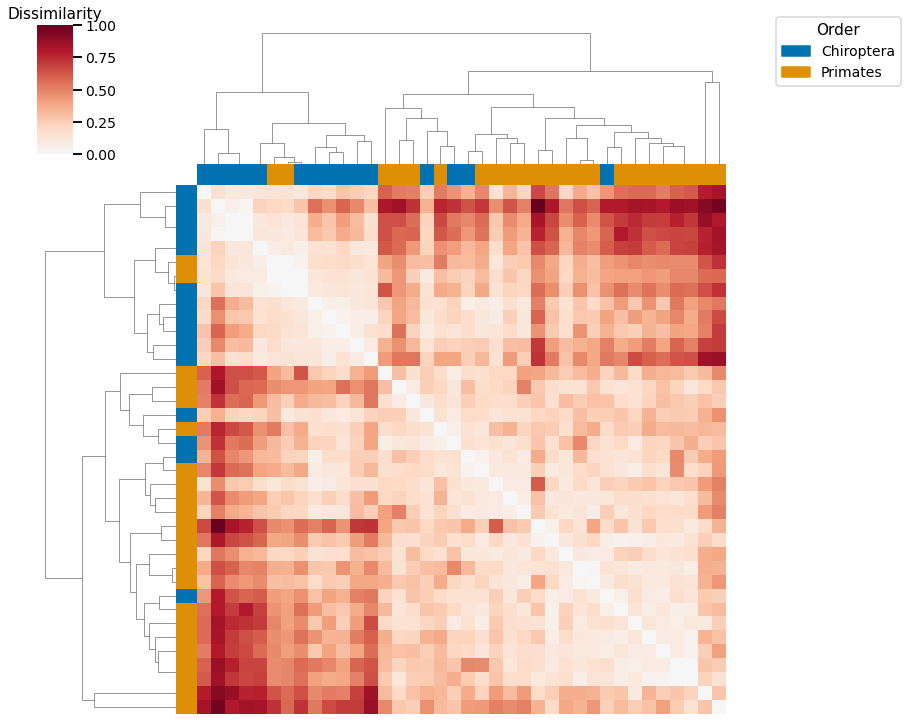

In [30]:
# cluster dissimilarity matrix
scaled_latent_dissim[scaled_latent_dissim < 0] = 0
latent_linkage_matrix, latent_pred = cluster_dissim(scaled_latent_dissim, y, method="agg")

# calculate accuracy and ARI
latent_pred = remap_labels(y, latent_pred)
latent_agg_score = accuracy_score(y, latent_pred)
latent_agg_ari = adjusted_rand_score(y, latent_pred)

print(f"Accuracy: {latent_agg_score}")
print(f"ARI: {latent_agg_ari}")

# plot clustered dissimilarity matrix
plot_clustering(labels, 'agg', scaled_latent_dissim, latent_linkage_matrix)

## GMM

We used classical multidimensional scaling to embed the dissimilarity matrices into a 2-dimensional space, then we used GMM to cluster these points. We assigned the number of components to be 4 since there are 4 genotypes, and the clusters are visualized with a scattermap below. The colors indicate the predicated genotypes, and the shapes (O or X) indicate whether or not those predictions were correct. 

For each kernel, the accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index, a similarity measure between two clusterings after being adjusted for chance, were reported. 

### Density

Accuracy: 0.7368421052631579
ARI: 0.19552068007193069


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

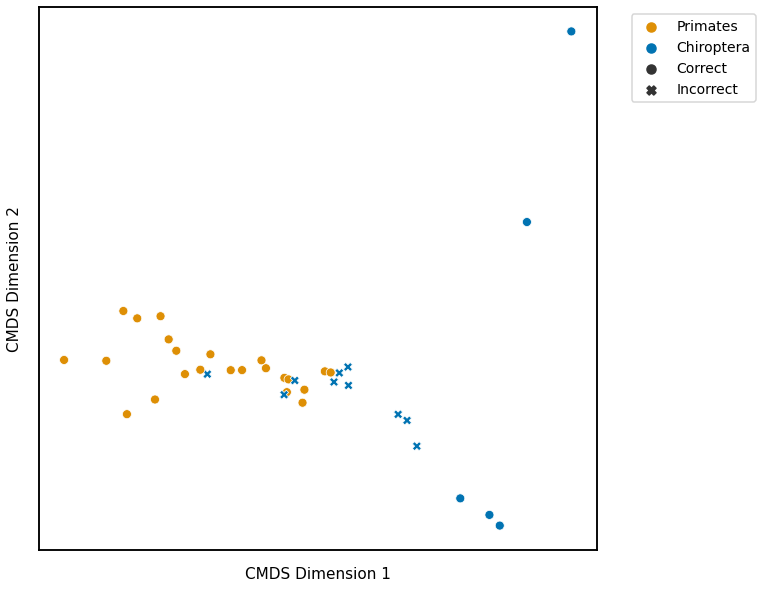

In [11]:
# cluster dissimilarity matrix
density_gm_embedding, density_gm_pred = cluster_dissim(scaled_density_dissim, y, method='gmm')
density_gm, density_gm_pred = construct_df(density_gm_embedding, labels, y, density_gm_pred)

# calculate accuracy and ARI
density_gm_score = accuracy_score(y, density_gm_pred)
density_gm_ari = adjusted_rand_score(y, density_gm_pred)

print(f"Accuracy: {density_gm_score}")
print(f"ARI: {density_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=density_gm)


### Average Edge Weight

Accuracy: 0.5526315789473685
ARI: -0.01948207575911445


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

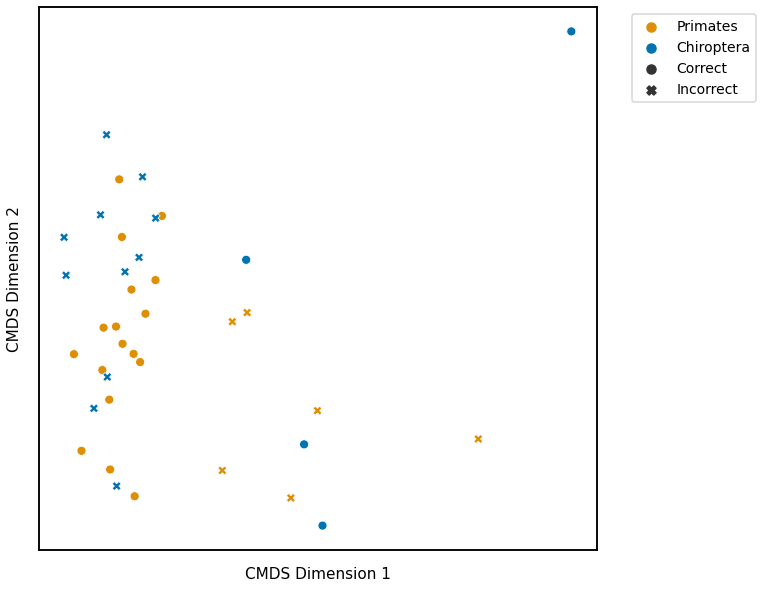

In [12]:
# cluster dissimilarity matrix
avgedgeweight_gm_embedding, avgedgeweight_gm_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method='gmm')
avgedgeweight_gm, avgedgeweight_gm_pred = construct_df(avgedgeweight_gm_embedding, labels, y, avgedgeweight_gm_pred)

# calculate accuracy and ARI
avgedgeweight_gm_score = accuracy_score(y, avgedgeweight_gm_pred)
avgedgeweight_gm_ari = adjusted_rand_score(y, avgedgeweight_gm_pred)

print(f"Accuracy: {avgedgeweight_gm_score}")
print(f"ARI: {avgedgeweight_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=avgedgeweight_gm)


### Average of the Adjacency Matrix

Accuracy: 0.7368421052631579
ARI: 0.19552068007193069


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

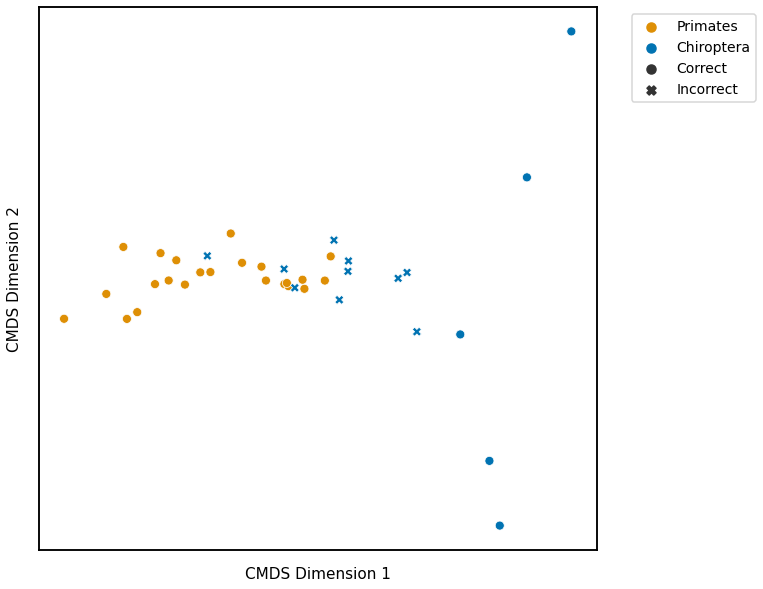

In [13]:
# cluster dissimilarity matrix
avgadjmat_gm_embedding, avgadjmat_gm_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method="gmm")
avgadjmat_gm, avgadjmat_gm_pred = construct_df(avgadjmat_gm_embedding, labels, y, avgadjmat_gm_pred)

# calculate accuracy and ARI
avgadjmat_gm_score = accuracy_score(y, avgadjmat_gm_pred)
avgadjmat_gm_ari = adjusted_rand_score(y, avgadjmat_gm_pred)

print(f"Accuracy: {avgadjmat_gm_score}")
print(f"ARI: {avgadjmat_gm_ari}")


# plot clustering
plot_clustering(labels, 'gmm', data=avgadjmat_gm)


### Spectral Distance (Laplacian)

Accuracy: 0.7894736842105263
ARI: 0.31234614193253885


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

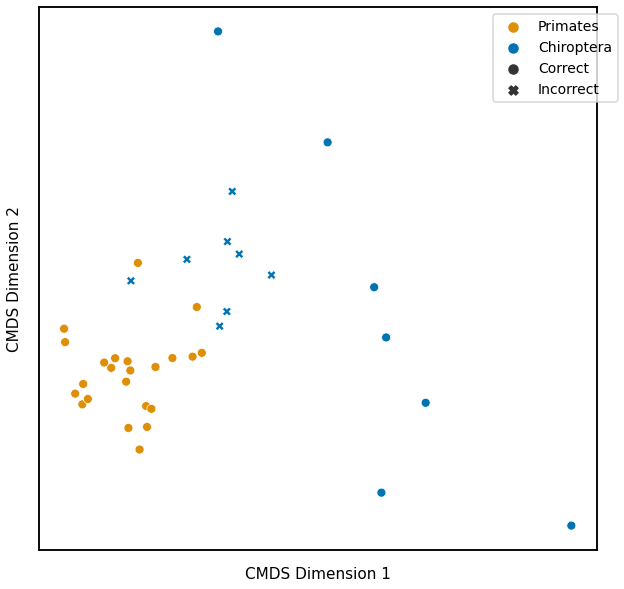

In [34]:
# cluster dissimilarity matrix
lap_gm_embedding, lap_gm_pred = cluster_dissim(scaled_lap_dissim, y, method="gmm")
lap_gm, lap_gm_pred = construct_df(lap_gm_embedding, labels, y, lap_gm_pred)

# calculate accuracy and ARI
lap_gm_score = accuracy_score(y, lap_gm_pred)
lap_gm_ari = adjusted_rand_score(y, lap_gm_pred)

print(f"Accuracy: {lap_gm_score}")
print(f"ARI: {lap_gm_ari}")


# plot clustering
plot_clustering(labels, 'gmm', data=lap_gm)


### Node Degrees

Accuracy: 0.8157894736842105
ARI: 0.37900307341596956


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

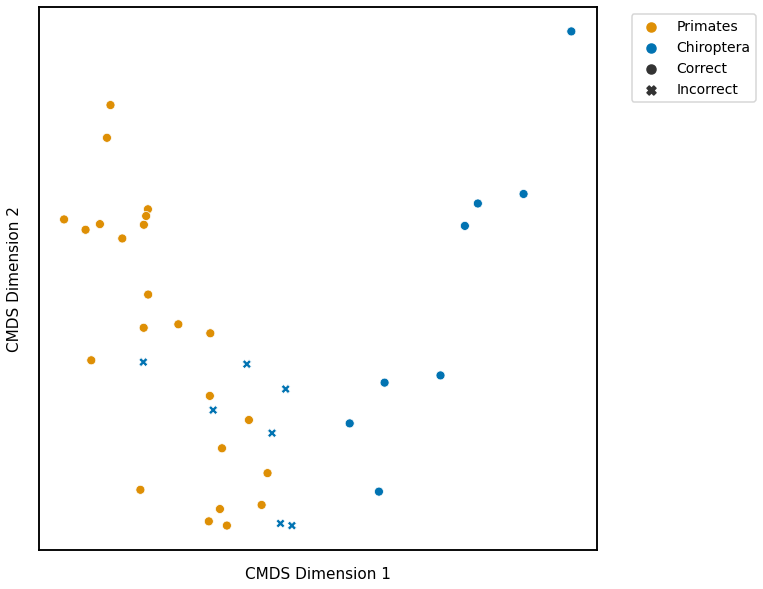

In [14]:
# cluster dissimilarity matrix
nodedeg_gm_embedding, nodedeg_gm_pred = cluster_dissim(scaled_nodedeg_dissim, y, method="gmm")
nodedeg_gm, nodedeg_gm_pred = construct_df(nodedeg_gm_embedding, labels, y, nodedeg_gm_pred)

# calculate accuracy and ARI
nodedeg_gm_score = accuracy_score(y, nodedeg_gm_pred)
nodedeg_gm_ari = adjusted_rand_score(y, nodedeg_gm_pred)

print(f"Accuracy: {nodedeg_gm_score}")
print(f"ARI: {nodedeg_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=nodedeg_gm)

### Node Strength

Accuracy: 0.6842105263157895
ARI: 0.11263229439751432


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

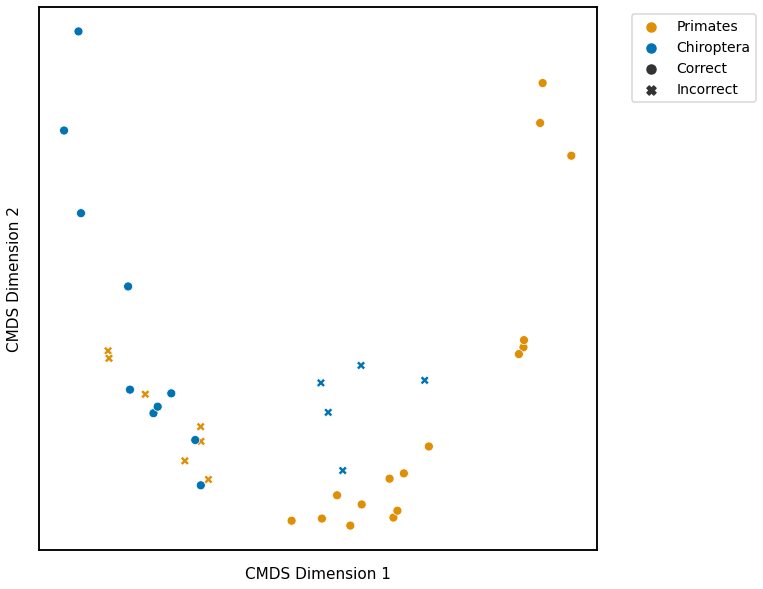

In [15]:
# cluster dissimilarity matrix
nodestr_gm_embedding, nodestr_gm_pred = cluster_dissim(scaled_nodestr_dissim, y, method="gmm")
nodestr_gm, nodestr_gm_pred = construct_df(nodestr_gm_embedding, labels, y, nodestr_gm_pred)

# calculate accuracy and ARI
nodestr_gm_score = accuracy_score(y, nodestr_gm_pred)
nodestr_gm_ari = adjusted_rand_score(y, nodestr_gm_pred)

print(f"Accuracy: {nodestr_gm_score}")
print(f"ARI: {nodestr_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=nodestr_gm)

### Edge Weights

Accuracy: 0.6578947368421053
ARI: 0.0647883980139417


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

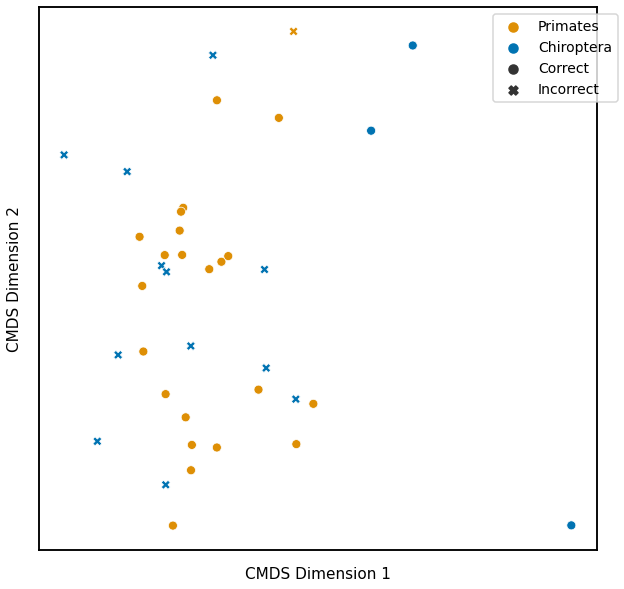

In [16]:
# cluster dissimilarity matrix
edgeweight_gm_embedding, edgeweight_gm_pred = cluster_dissim(scaled_edgeweight_dissim, y, method="gmm")
edgeweight_gm, edgeweight_gm_pred = construct_df(edgeweight_gm_embedding, labels, y, edgeweight_gm_pred)

# calculate accuracy and ARI
edgeweight_gm_score = accuracy_score(y, edgeweight_gm_pred)
edgeweight_gm_ari = adjusted_rand_score(y, edgeweight_gm_pred)

print(f"Accuracy: {edgeweight_gm_score}")
print(f"ARI: {edgeweight_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=edgeweight_gm)

### Latent Distribution

Accuracy: 0.7894736842105263
ARI: 0.31755302797417767


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

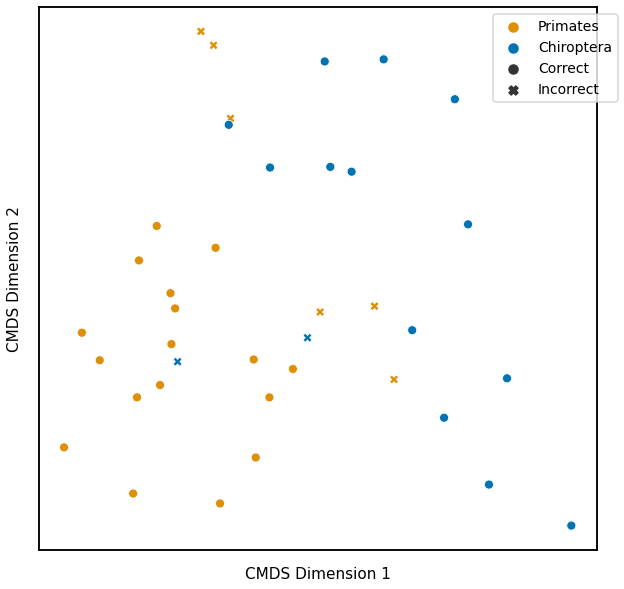

In [27]:
# cluster dissimilarity matrix
scaled_latent_dissim[scaled_latent_dissim < 0] = 0
latent_gm_embedding, latent_gm_pred = cluster_dissim(scaled_latent_dissim, y, method="gmm")
latent_gm, latent_gm_pred = construct_df(latent_gm_embedding, labels, y, latent_gm_pred)

# calculate accuracy and ARI
latent_gm_score = accuracy_score(y, latent_gm_pred)
latent_gm_ari = adjusted_rand_score(y, latent_gm_pred)

print(f"Accuracy: {latent_gm_score}")
print(f"ARI: {latent_gm_ari}")

# plot clustering
plot_clustering(labels, 'gmm', data=latent_gm)

## K-Means

Similar to GMM, we first used classical multidimensional scaling to embed the dissimilarity matrices into a 2-dimensional space, then used the K-Means clustering algorithm to predict the genotypes of each point. The clusters are shown in the scatterplot below, and the colors represent the predicted genotypes and the shapes (O or X) indicate whether or not those predictions were correct.

For each kernel, the raw accuracy score, the number of correct predictions divided by the total number of samples, and the adjusted rand index, a similarity measure between two clusterings after being adjusted for chance, were reported. 

### Density

Accuracy: 0.868421052631579
ARI: 0.5302001190751023


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

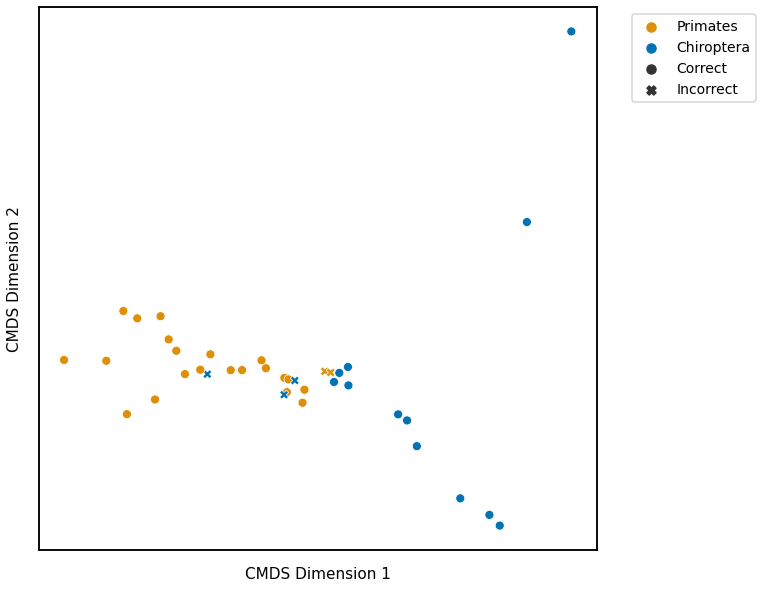

In [18]:
# cluster dissimilarity matrix
density_km_embedding, density_km_pred = cluster_dissim(scaled_density_dissim, y, method="kmeans")
density_km, density_km_pred = construct_df(density_km_embedding, labels, y, density_km_pred)

# calculate accuracy and ARI
density_km_score = accuracy_score(y, density_km_pred)
density_km_ari = adjusted_rand_score(y, density_km_pred)

print(f"Accuracy: {density_km_score}")
print(f"ARI: {density_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=density_km)

### Average Edge Weight

Accuracy: 0.5526315789473685
ARI: -0.01948207575911445


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

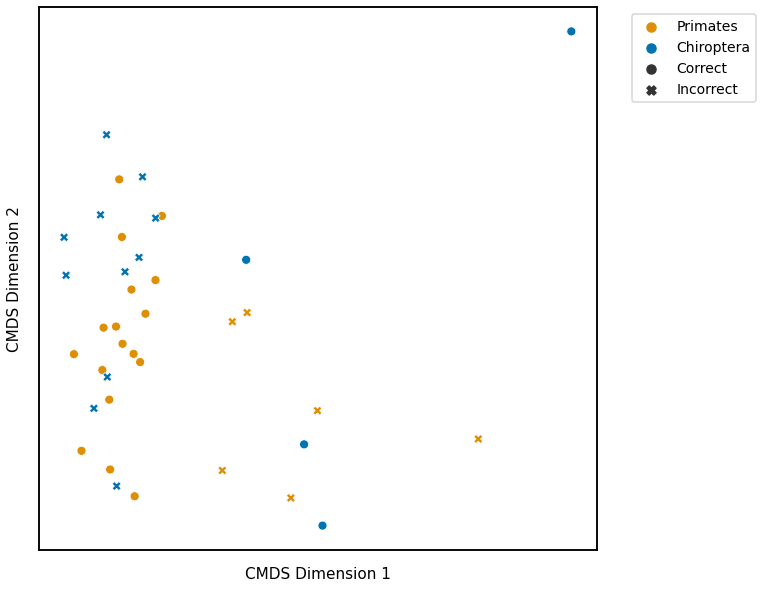

In [19]:
# cluster dissimilarity matrix
avgedgeweight_km_embedding, avgedgeweight_km_pred = cluster_dissim(scaled_avgedgeweight_dissim, y, method='kmeans')
avgedgeweight_km, avgedgeweight_km_pred = construct_df(avgedgeweight_km_embedding, labels, y, avgedgeweight_km_pred)

# calculate accuracy and ARI
avgedgeweight_km_score = accuracy_score(y, avgedgeweight_km_pred)
avgedgeweight_km_ari = adjusted_rand_score(y, avgedgeweight_km_pred)

print(f"Accuracy: {avgedgeweight_km_score}")
print(f"ARI: {avgedgeweight_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=avgedgeweight_km)

### Average of the Adjacency Matrix

Accuracy: 0.868421052631579
ARI: 0.5302001190751023


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

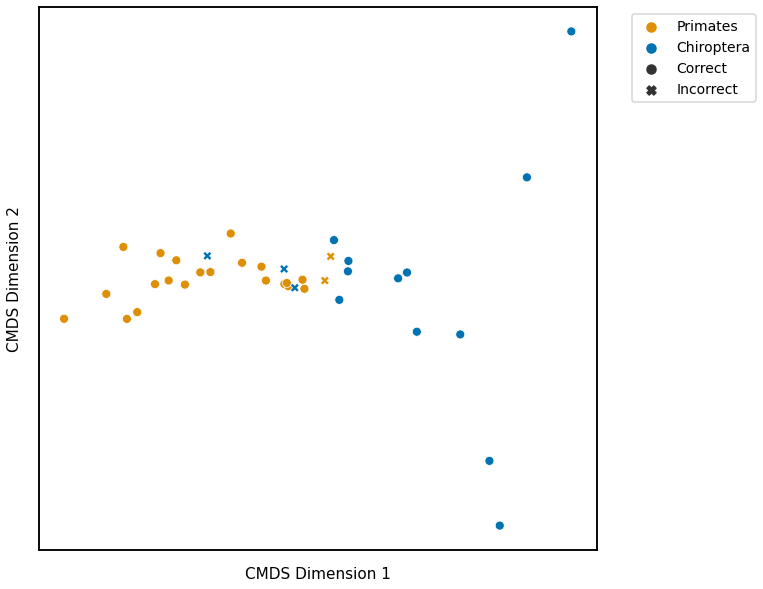

In [20]:
# cluster dissimilarity matrix
avgadjmat_km_embedding, avgadjmat_km_pred = cluster_dissim(scaled_avgadjmat_dissim, y, method='kmeans')
avgadjmat_km, avgadjmat_km_pred = construct_df(avgadjmat_km_embedding, labels, y, avgadjmat_km_pred)

# calculate accuracy and ARI
avgadjmat_km_score = accuracy_score(y, avgadjmat_km_pred)
avgadjmat_km_ari = adjusted_rand_score(y, avgadjmat_km_pred)

print(f"Accuracy: {avgadjmat_km_score}")
print(f"ARI: {avgadjmat_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=avgadjmat_km)

### Spectral Distance (Laplacian)

Accuracy: 0.7894736842105263
ARI: 0.31234614193253885


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

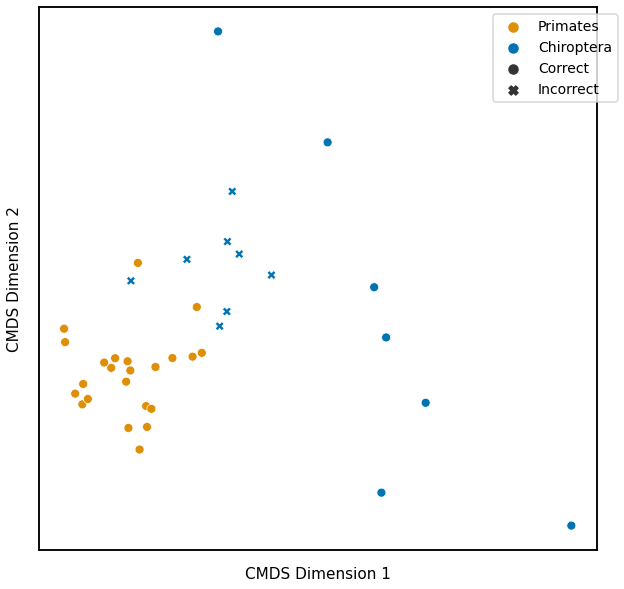

In [35]:
# cluster dissimilarity matrix
lap_km_embedding, lap_km_pred = cluster_dissim(scaled_lap_dissim, y, method="gmm")
lap_km, lap_km_pred = construct_df(lap_km_embedding, labels, y, lap_km_pred)

# calculate accuracy and ARI
lap_km_score = accuracy_score(y, lap_km_pred)
lap_km_ari = adjusted_rand_score(y, lap_km_pred)

print(f"Accuracy: {lap_km_score}")
print(f"ARI: {lap_km_ari}")


# plot clustering
plot_clustering(labels, 'gmm', data=lap_km)

### Node Degree

Accuracy: 0.8157894736842105
ARI: 0.37900307341596956


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

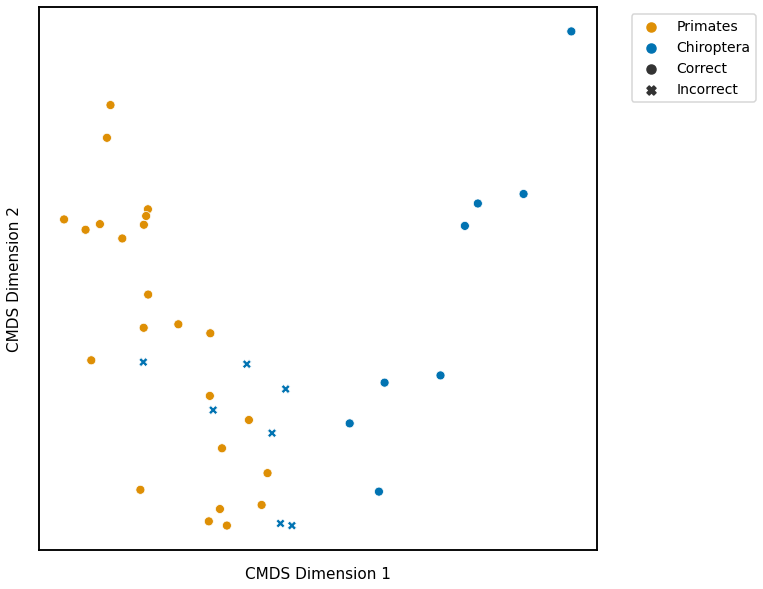

In [21]:
# cluster dissimilarity matrix
nodedeg_km_embedding, nodedeg_km_pred = cluster_dissim(scaled_nodedeg_dissim, y, method='kmeans')
nodedeg_km, nodedeg_km_pred = construct_df(nodedeg_km_embedding, labels, y, nodedeg_km_pred)

# calculate accuracy and ARI
nodedeg_km_score = accuracy_score(y, nodedeg_km_pred)
nodedeg_km_ari = adjusted_rand_score(y, nodedeg_km_pred)

print(f"Accuracy: {nodedeg_km_score}")
print(f"ARI: {nodedeg_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=nodedeg_km)

### Node Strength

Accuracy: 0.6842105263157895
ARI: 0.11263229439751432


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

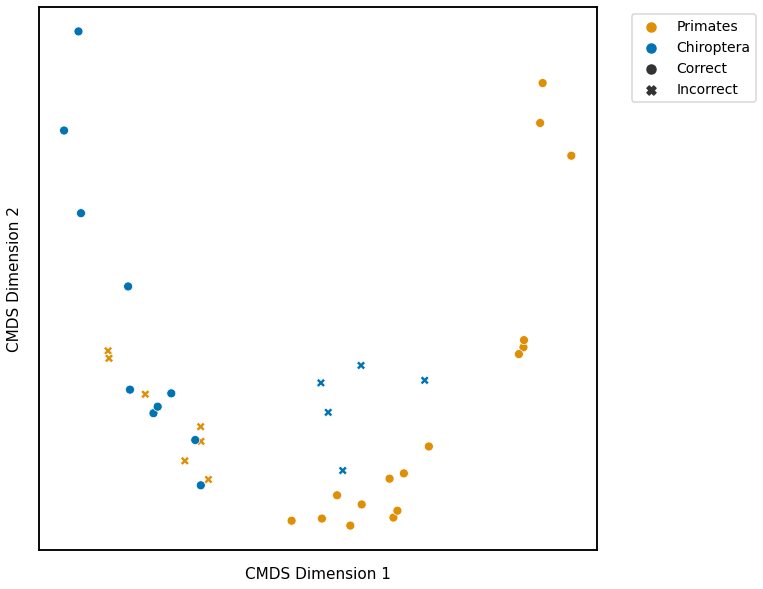

In [22]:
# cluster dissimilarity matrix
nodestr_km_embedding, nodestr_km_pred = cluster_dissim(scaled_nodestr_dissim, y, method='kmeans')
nodestr_km, nodestr_km_pred = construct_df(nodestr_km_embedding, labels, y, nodestr_km_pred)

# calculate accuracy and ARI
nodestr_km_score = accuracy_score(y, nodestr_km_pred)
nodestr_km_ari = adjusted_rand_score(y, nodestr_km_pred)

print(f"Accuracy: {nodestr_km_score}")
print(f"ARI: {nodestr_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=nodestr_km)

### Edge Weight

Accuracy: 0.631578947368421
ARI: 0.04134807383236741


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

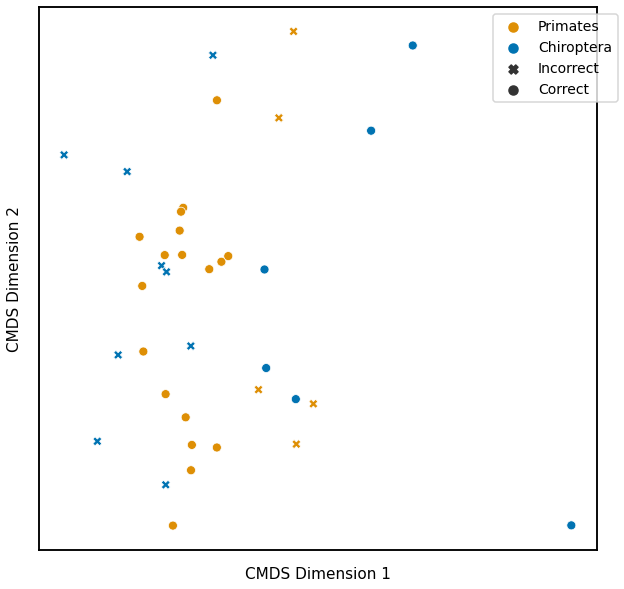

In [23]:
# cluster dissimilarity matrix
edgeweight_km_embedding, edgeweight_km_pred = cluster_dissim(scaled_edgeweight_dissim, y, method='kmeans')
edgeweight_km, edgeweight_km_pred = construct_df(edgeweight_km_embedding, labels, y, edgeweight_km_pred)

# calculate accuracy and ARI
edgeweight_km_score = accuracy_score(y, edgeweight_km_pred)
edgeweight_km_ari = adjusted_rand_score(y, edgeweight_km_pred)

print(f"Accuracy: {edgeweight_km_score}")
print(f"ARI: {edgeweight_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=edgeweight_km)

### Latent Distribution

Accuracy: 0.8421052631578947
ARI: 0.453582705853777


<AxesSubplot:xlabel='CMDS Dimension 1', ylabel='CMDS Dimension 2'>

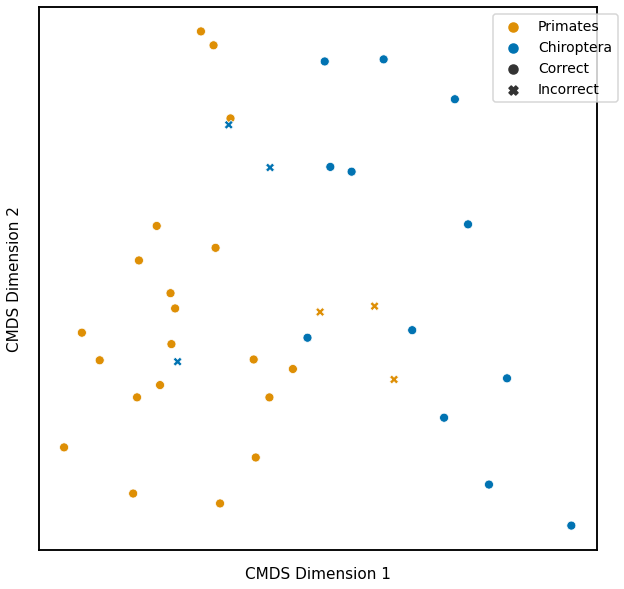

In [28]:
# cluster dissimilarity matrix
scaled_latent_dissim[scaled_latent_dissim < 0] = 0
latent_km_embedding, latent_km_pred = cluster_dissim(scaled_latent_dissim, y, method='kmeans')
latent_km, latent_km_pred = construct_df(latent_km_embedding, labels, y, latent_km_pred)

# calculate accuracy and ARI
latent_km_score = accuracy_score(y, latent_km_pred)
latent_km_ari = adjusted_rand_score(y, latent_km_pred)

print(f"Accuracy: {latent_km_score}")
print(f"ARI: {latent_km_ari}")

# plot clustering
plot_clustering(labels, 'kmeans', data=latent_km)

## ARI Plot

We will use the adjusted rand index (ARI) to compare the performace of each clustering algorithm on each kernel. The ARI values are visualized with a scatter plot below, and the colors represent the different clustering algorithms.

In [25]:
from graspologic.utils import symmetrize

# construct symmetric random matrix with zero diagonal
np.random.seed(3)
scaled_random = np.random.rand(len(graphs), len(graphs))
scaled_random = symmetrize(scaled_random)

# agglomerative clustering
random_linkage_matrix, random_pred = cluster_dissim(scaled_random, y, method="agg")
random_pred = remap_labels(y, random_pred)
random_agg_score = accuracy_score(y, random_pred)
random_agg_ari = adjusted_rand_score(y, random_pred)

# GMM
random_gm_embedding, random_gm_pred = cluster_dissim(scaled_random, y, method="gmm")
random_gm, random_gm_pred = construct_df(random_gm_embedding, labels, y, random_gm_pred)
random_gm_score = accuracy_score(y, random_gm_pred)
random_gm_ari = adjusted_rand_score(y, random_gm_pred)

# K-Means
random_km_embedding, random_km_pred = cluster_dissim(scaled_random, y, method="kmeans")
random_km, random_km_pred = construct_df(random_km_embedding, labels, y, random_km_pred)
random_km_score = accuracy_score(y, random_km_pred)
random_km_ari = adjusted_rand_score(y, random_km_pred)

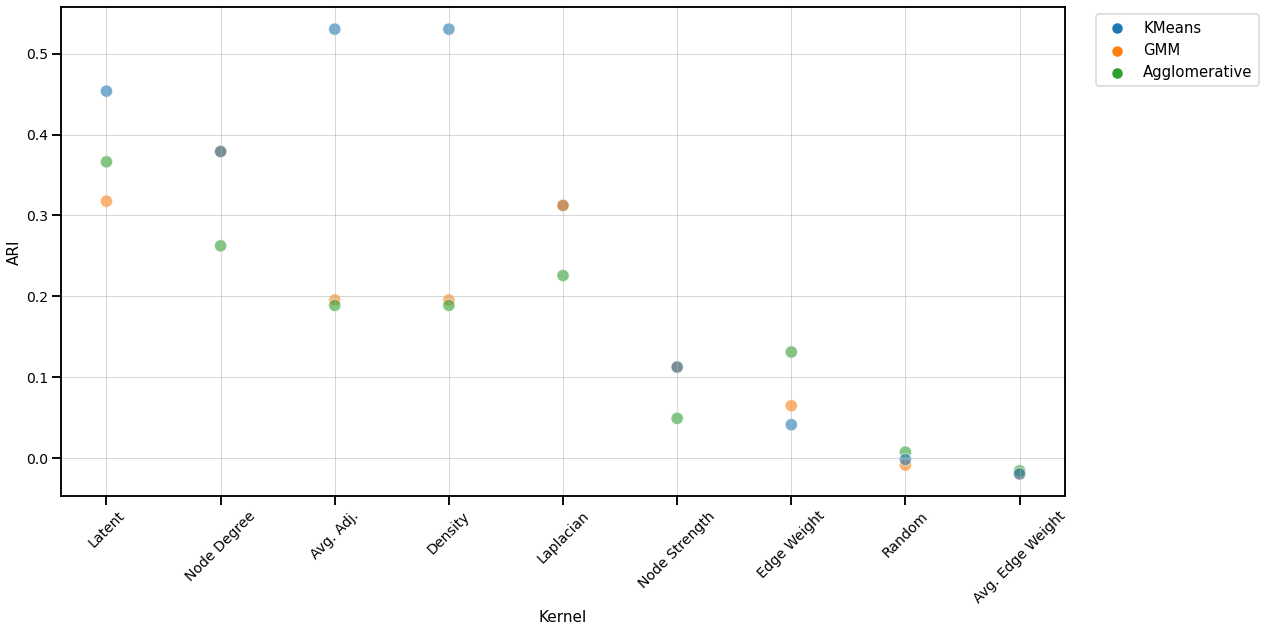

In [36]:
kernels = ['Density', 'Avg. Edge Weight', 'Avg. Adj.', 'Laplacian', 'Node Degree', 'Node Strength', \
    'Edge Weight', 'Latent', 'Random']
kernels_df = [kernel for kernel in kernels for i in range(3)]
agg_ari = [density_agg_ari, avgedgeweight_agg_ari, avgadjmat_agg_ari, lap_agg_ari, nodedeg_agg_ari, \
    nodestr_agg_ari, edgeweight_agg_ari, latent_agg_ari, random_agg_ari]
gm_ari = [density_gm_ari, avgedgeweight_gm_ari, avgadjmat_gm_ari, lap_gm_ari, nodedeg_gm_ari, \
    nodestr_gm_ari, edgeweight_gm_ari, latent_gm_ari, random_gm_ari]
km_ari = [density_km_ari, avgedgeweight_km_ari, avgadjmat_km_ari, lap_km_ari, nodedeg_km_ari, \
    nodestr_km_ari, edgeweight_km_ari, latent_km_ari, random_km_ari]

ari_vals = np.vstack((np.array(agg_ari), np.array(gm_ari), np.array(km_ari)))
ari_vals = np.ravel(ari_vals.T)
algos = ['Agglomerative', 'GMM', 'KMeans'] * len(agg_ari)

ari_df = pd.DataFrame(list(zip(kernels_df, ari_vals, algos)), columns=["Kernel", "ARI", "Algorithm"])

avg_ari_vals = (np.array(agg_ari) + np.array(gm_ari) + np.array(km_ari)) / 3
avg_ari_vals = [val for val in avg_ari_vals for i in range(3)]
ari_df["Average"] = avg_ari_vals
ari_df = ari_df.sort_values(by=['Average'], ascending=False)

fig, ax = plt.subplots(1,1, figsize=(18, 9), facecolor='w')
sns.set_context("talk", font_scale=0.9)
sns.scatterplot(x="Kernel", y="ARI", hue="Algorithm", data=ari_df, alpha=0.6, s=150)
plt.legend(bbox_to_anchor = (1.2, 1))
plt.xticks(rotation=45)
plt.grid(linewidth=0.5)